## Sommaire :
1. **[Contexte du projet](#context__projet)**
2. **[Import des librairies](#import__packages)**
3. **[Récuperation et analyse globale des données](#load__data)**
4. **[Nettoyage des données](#data__preparation)**
    - 4.1 - [Suppression des valeurs aberrantes](#remove__outliers)
    - 4.2 - [Traitement des valeurs manquantes](#treat__missing__values)   
5. **[Exploration et analyses de corrélation des variables](#exploratory__data__analysis)**
    - 5.1 - [Matrice de correlation](#correlation__matrix)
    - 5.2 - [Création des nouvelles variables](#create__features)
6. **[Préparation des variables](#prepare__features__models)**    
    - 6.1 - [Transformation de la variable cible](#target__variable)
    - 6.2 - [Normalisation des variables numériques](#treating__skewed__features)
    - 6.3 - [Préparation des variables catégorielles](#preparation__of__cat__features)
7. **[Modélisation](#modeling)**
    - 7.1 - [Entrainement du modèle](#training)
    - 7.2 - [Optimisation](#optimisation)
    - 7.3 - [Combinaison des modèles](#stacking)
    - 7.4 - [Sauvegarde du résultat](#submission)
8. **[Conclusion](#conclusion)**   

<a id='context__projet'></a>
# 1. 
## Contexte du projet

Ce projet est un concours Kaggle sur le thème de prédiction de prix de biens immobiliers à partir des plusieurs variables.

Les agents immobiliers se basent sur quelques points clés pour estimer les prix:
- **Localisation** - La localisation est essentielle pour l'estimation d'un bien immobilier, par conséquent, avoir une maison sûre, bien aménagée et bien positionnée dans un bon quartier est également un facteur important.
- **Surface** - Plus la maison a un volume important, de pièces et de terrain, plus la valeur est élevée.
- **Autres** - les variables supplementaires (comme un garage) sont hautement souhaitables.

Ces elements vous nous guider pour la suite de notre étude.

Pour l'étude, il y aura différentes étapes : récupération, nettoyage des données, analyse exploratoire, création de plusieurs modèles et mesure de leurs performances.

***

***

<a id='import__packages'></a>
# 2. 
## Import des librairies

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from mlxtend.regressor import StackingCVRegressor
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from pandas.api.types import CategoricalDtype
from lightgbm import LGBMRegressor

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

mycolors = ["#66c2ff", "#5cd6d6", "#00cc99", "#85e085", "#ffd966", "#ffb366", "#ffb3b3", "#dab3ff", "#c2c2d6"]
sns.set_palette(palette = mycolors, n_colors = 4)

***

<a id='load__data'></a>
# 3. 
## Récuperation des données

#### Chargement des données

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Enregistrons les Id d'entrainement et de test
train_ID = train['Id']
test_ID = test['Id']

# Supprimons les id pour ne pas avoir des redondaces
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [3]:
print('Entrainement : {} lignes et {} colonnes.'.format(train.shape[0],
                                                        train.shape[1]))
print('Test : {} lignes et {} colonnes.'.format(test.shape[0], test.shape[1]))

Entrainement : 1460 lignes et 80 colonnes.
Test : 1459 lignes et 79 colonnes.


#### Analyse globale des données

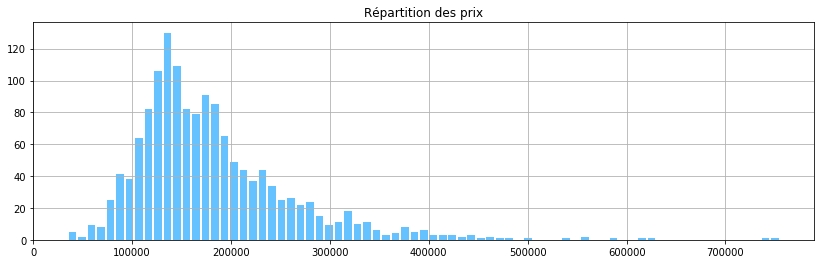

In [4]:
train.SalePrice.hist(bins=75, rwidth=.8, figsize=(14, 4))
plt.title('Répartition des prix')
plt.show()

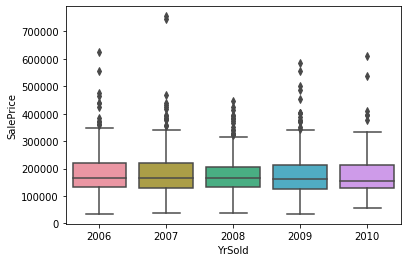

In [5]:
# Variation des prix de vente des logement selon l'année de vente
ax = sns.boxplot(x="YrSold", y="SalePrice", data=train)
plt.show()

Text(0.5, 1.0, 'Période de construction et de rénovation ')

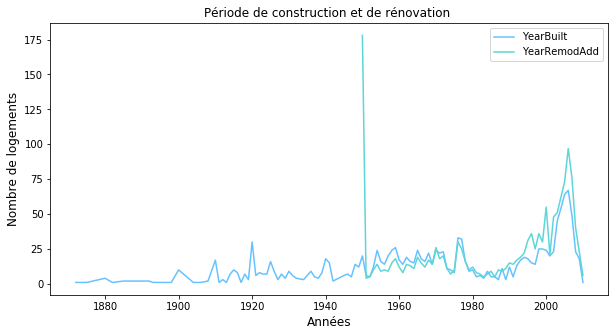

In [6]:
plt.figure(figsize=(10, 5))
# Date de construction
train.YearBuilt.value_counts().sort_index().plot()
plt.legend(loc='best')
# Date de Renovation
train.YearRemodAdd.value_counts().sort_index().plot()
plt.legend(loc='best')
plt.xlabel('Années', fontsize=12)
plt.ylabel('Nombre de logements', fontsize=12)
plt.title('Période de construction et de rénovation ')

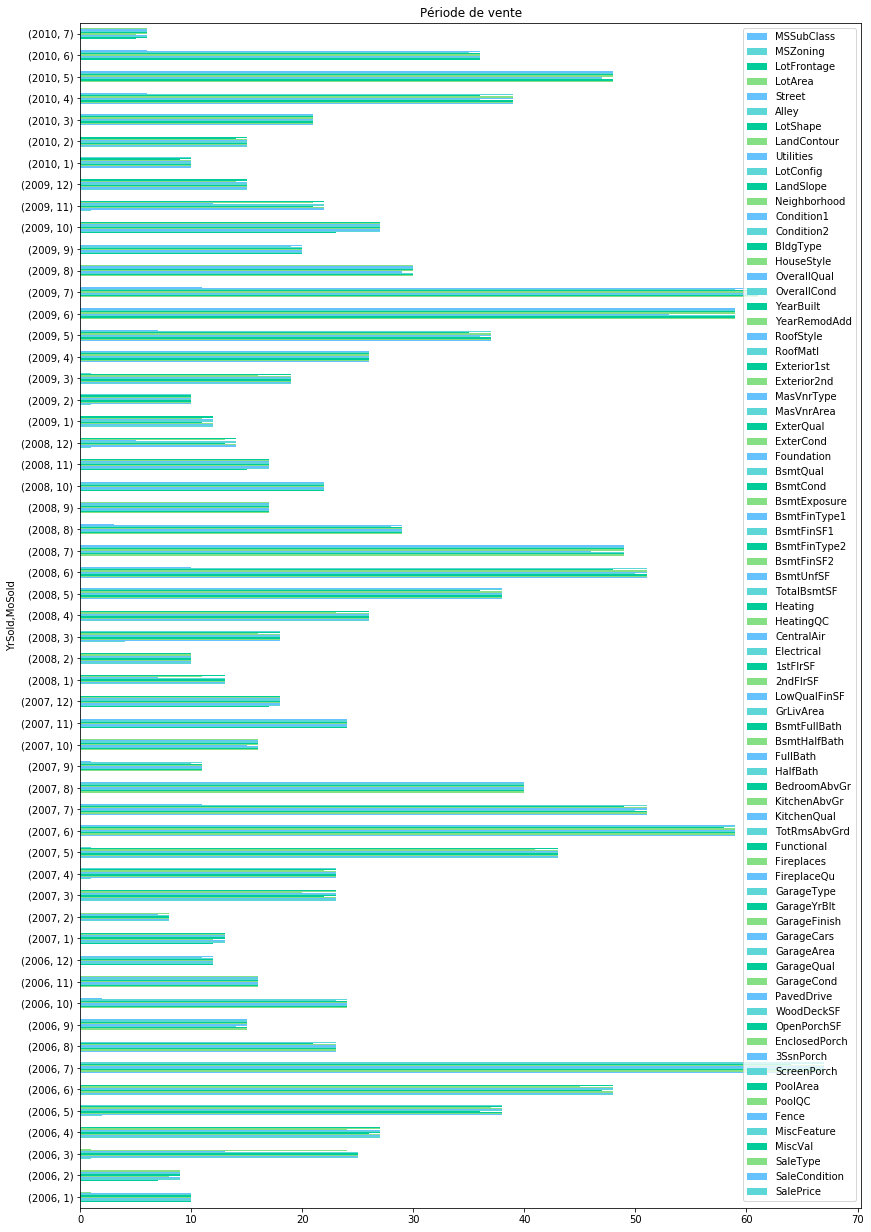

In [7]:
train.groupby(['YrSold', 'MoSold']).count().plot(kind='barh',
                                                    figsize=(14, 21.8))
plt.title('Période de vente')
plt.show()

***

<a id='data__preparation'></a>
# 3. 
## Préparation des données

<a id='remove__outliers'></a>
### 3.1 - Suppression des valeurs aberrantes

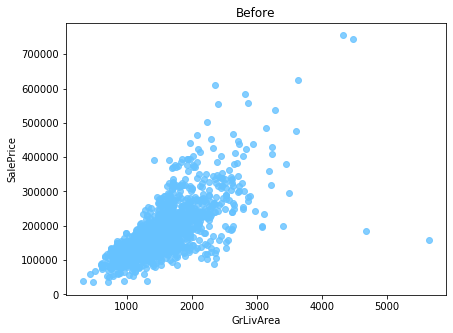

In [8]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("Before")



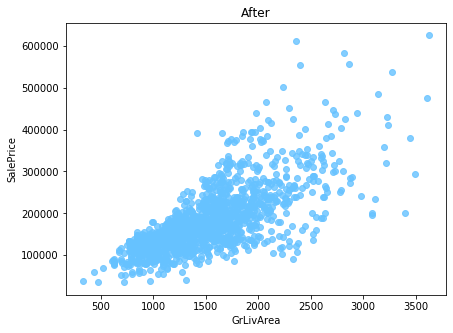

In [9]:
# Suppression des outliers
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['GrLivArea']>4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title("After")

***

<a id='treat__missing__values'></a>
### 3.2 - Traitement des valeurs manquantes


In [10]:
# tailles des données
ntrain = train.shape[0]
ntest = test.shape[0]

# enregistrer les valeurs de la variable cible
y_train = train.SalePrice.values

# concatener les données entrainement et test
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape: {}".format(all_data.shape))

all_data shape: (2915, 79)


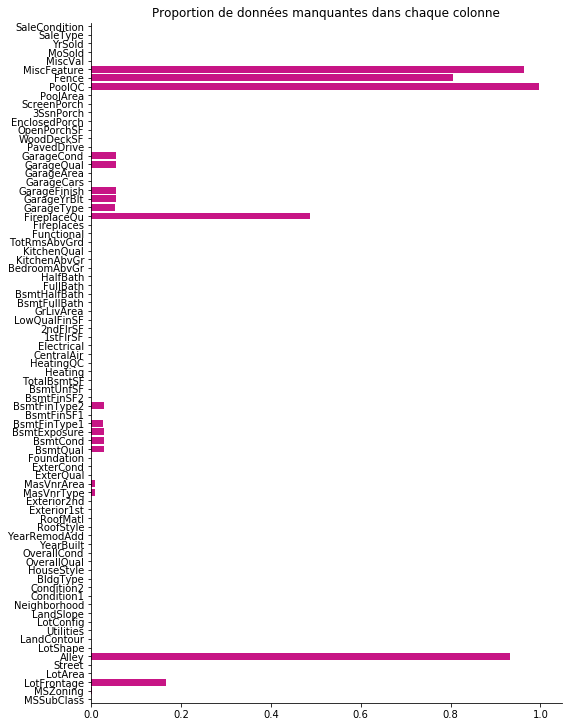

In [11]:
null_counts = all_data.isnull().mean(axis=0)

#   barplot des valeurs manquantes par colonne
fig = plt.figure(figsize=(8, 10))
plt.barh(np.arange(len(null_counts)), null_counts, color="mediumvioletred")
plt.yticks(np.arange(len(null_counts)), null_counts.index,
           rotation=0, fontsize=10)
sns.despine()
plt.margins(y=0)
plt.tight_layout()
plt.title('Proportion de données manquantes dans chaque colonne')
plt.show()

Grace au graphique ci-dessus, on peut voir où se situent les valeurs manquantes..

- Nous allons nous baser sur les explications de chaque variable dans l'énnoncé de Kaggle pour remplir ces variables manquantes mais aussi en utilisant nos intuitions pour certaines variables :

In [12]:
# Remplir les valeur  manquantes avec "None"
for col in ("PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu",
           "GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
            "BsmtFinType2", "MSSubClass", "MasVnrType"):
    all_data[col] = all_data[col].fillna("None")
print("'None' - traité")

# La superficie du terrain est susceptible d'être similaire aux maisons du quartier
# Par conséquent, utilisons la valeur médiane des maisons du quartier pour remplir cette valeur
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
print("'LotFrontage' - traité...")

# Remplir de 0 les valeurs manquantes pour sur ces variables  
for col in ("GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", 
           "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "MasVnrArea",
           "BsmtFullBath", "BsmtHalfBath"):
    all_data[col] = all_data[col].fillna(0)
print("'0' - traité...")


# On rempli les valeurs manquantes par la valeur la plus courante,car ces variables ont un faible nombre de valeurs manquantes
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna(all_data['Functional'].mode()[0])
print("'mode' - traité")

all_data_na = all_data.isnull().sum()
print("Variables avec des valeurs manquantes: ", all_data_na.drop(all_data_na[all_data_na == 0].index))

'None' - traité
'LotFrontage' - traité...
'0' - traité...
'mode' - traité
Variables avec des valeurs manquantes:  Utilities    2
dtype: int64


In [13]:
# Nombre de cardinalité pour les variables manquantes :
print('cardinalité de Utilities : ', all_data['Utilities'].nunique())
print(pd.crosstab(all_data.Utilities, columns="Utilities"))

cardinalité de Utilities :  2
col_0      Utilities
Utilities           
AllPub          2912
NoSeWa             1


In [14]:
# Suppression de la variable "Utilities"
all_data.drop("Utilities", axis=1, inplace=True)
print("Il reste {} valeurs manquantes".format(all_data.isnull().sum().sum()))

Il reste 0 valeurs manquantes


***

<a id='exploratory__data__analysis'></a>
# 5. 
## Explorations et analyses de correlation des variables

<a id='correlation__matrix'></a>
### 5.1 - Matrice des correlations

La matrice de correlation ci-dessous nous  orientera sur le choix des variables à prendre en compte ou des nouvelles variables à créer pour la suite de nos modèlisation.


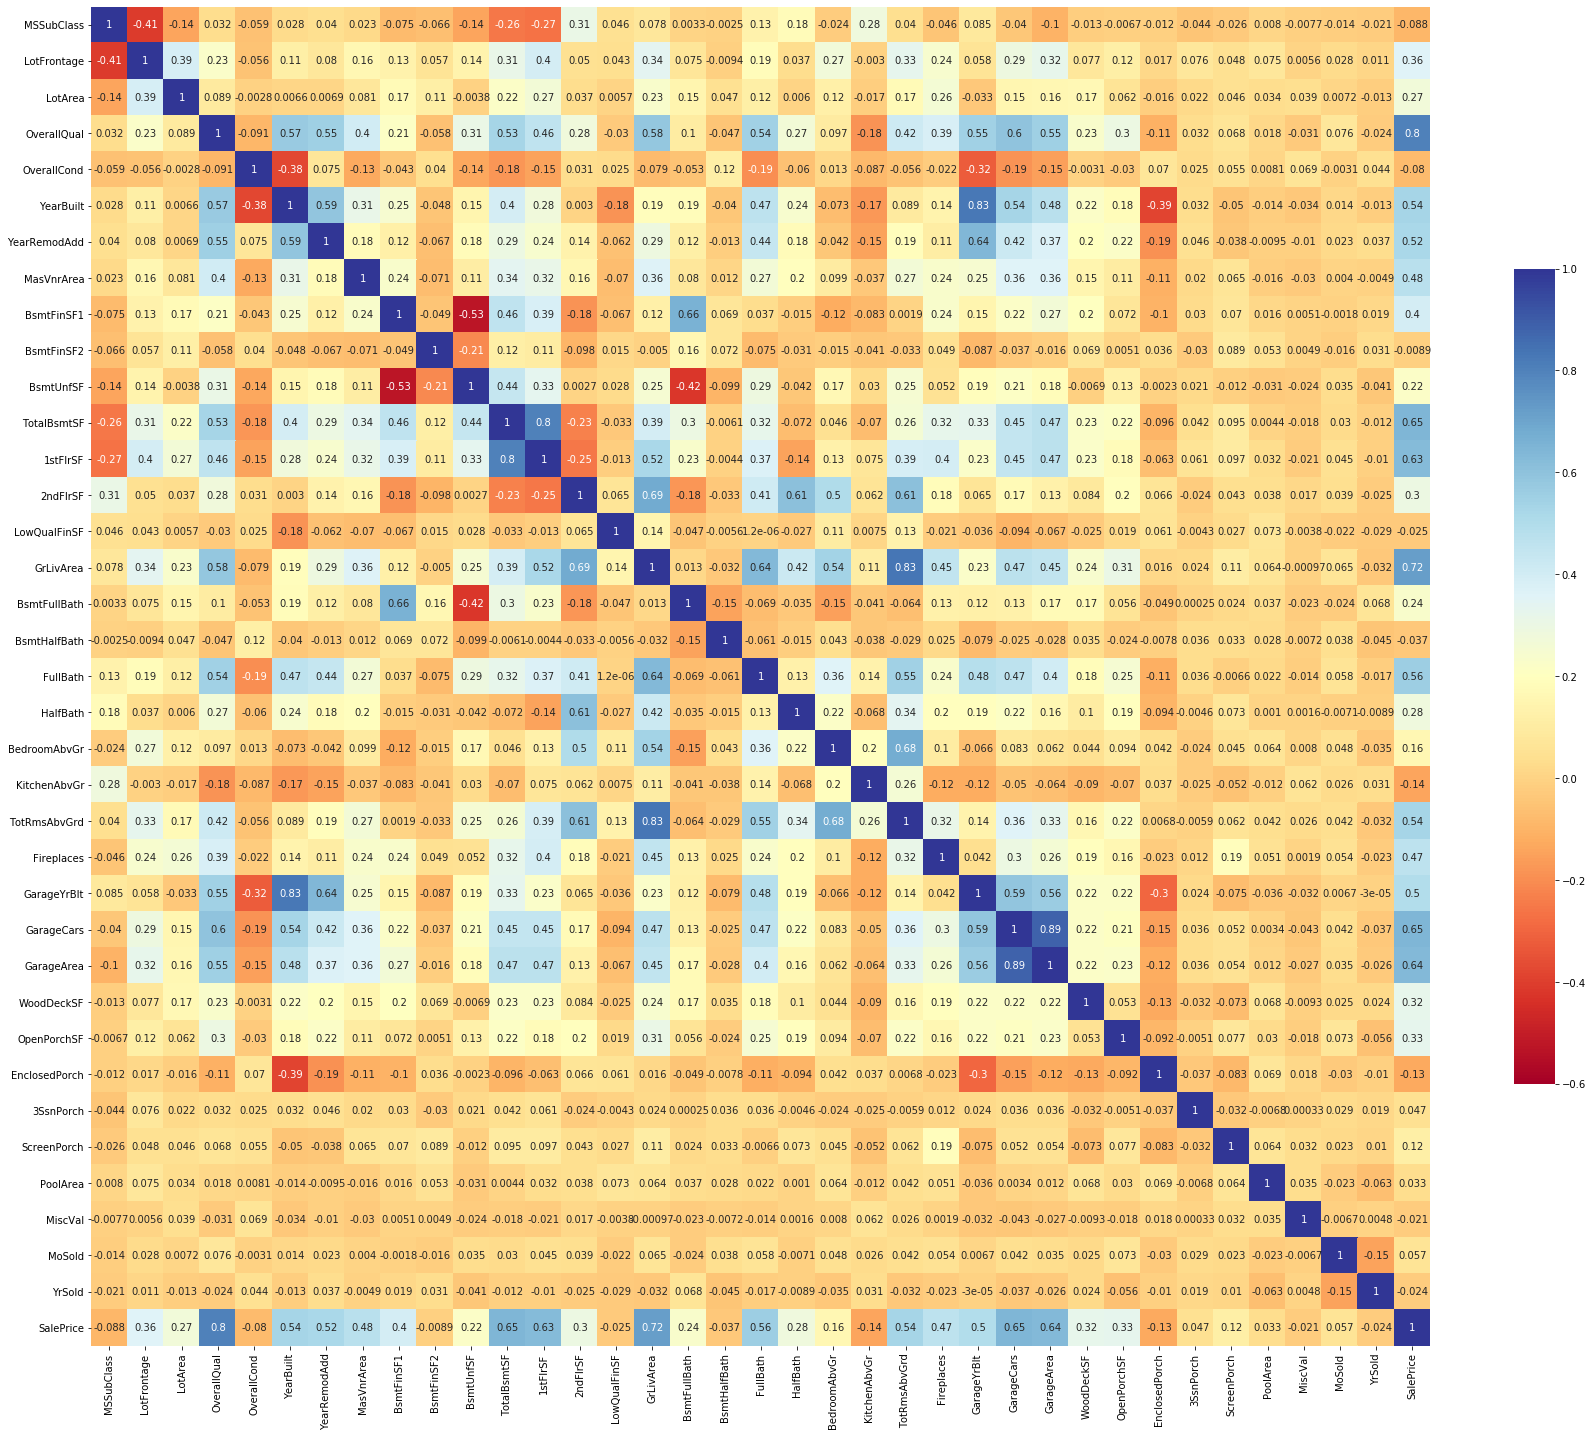

In [15]:
corr = train.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.6, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

<a id='create__features'></a>
### 5.2 - Création des nouvelles variables

In [16]:
# Creation de nouvelles variables
# Age du logement (Année de vente - Année de construction)
all_data['AgeHouse'] = all_data['YrSold']-all_data['YearBuilt']

# Indicatrice si le logement à été rénové ou pas:
# 1 si YearBuild <> YearRemodAdd et O sinon
all_data['RemodHouse'] = 1*(all_data.YearBuilt != all_data.YearRemodAdd)

# Surface totale du logement ( GrLivArea + TotalBsmtSF ) Superfiice du sol + superficie habitable
all_data["TotalArea"] = all_data["GrLivArea"]+all_data["TotalBsmtSF"]

# Ratio entre la surface habitable et la surface de la propriété
all_data["TotalArea"] = all_data["TotalArea"]/all_data["LotArea"]

# Ratio entre  Nbre Salles de bains / Nbre de chambres
all_data["BathRoomBedRoom"] = (all_data["FullBath"]+all_data["HalfBath"])/(1+all_data["BedroomAbvGr"])

all_data.drop("YearBuilt", axis=1, inplace=True)
all_data.drop("YearRemodAdd", axis=1, inplace=True)
all_data.drop("GarageYrBlt", axis=1, inplace=True)

In [18]:
all_data[['AgeHouse']]

,AgeHouse
0,5
1,31
2,7
3,91
4,8
...,...
2910,36
2911,36
2912,46
2913,14


<a id='prepare__features__models'></a>
# 6. 
## Préparation des variables


***

<a id='target__variable'></a>
### 6.1 - Transformation de la variable cible


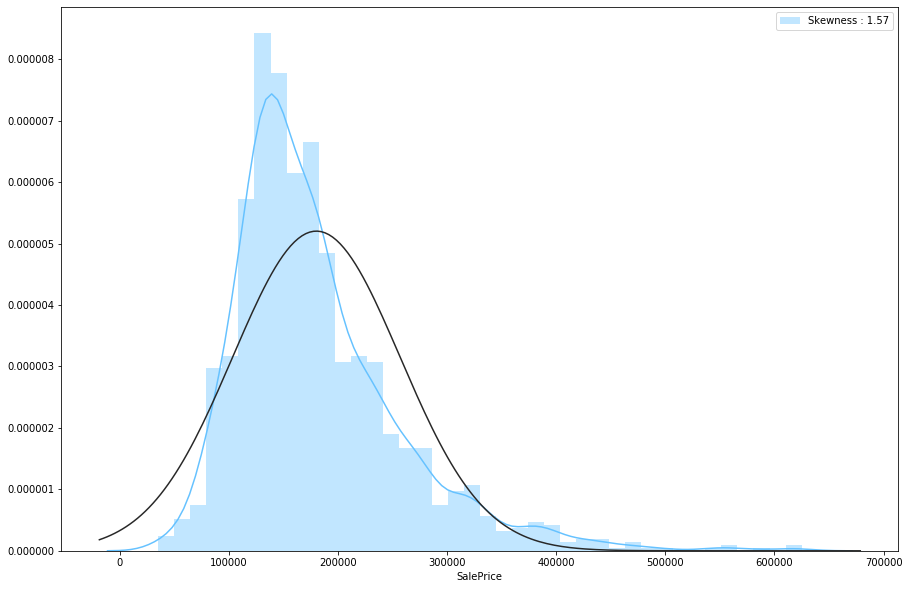

In [19]:
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

 La distribution de la variable cible est **positivement biaisée**, ce qui signifie que le mode est toujours inférieur à la moyenne et à la médiane

- Nous allons donc transformer avec la fonction logarithmique log(1+x) pour se rapprocher le plus de la courbe en noir

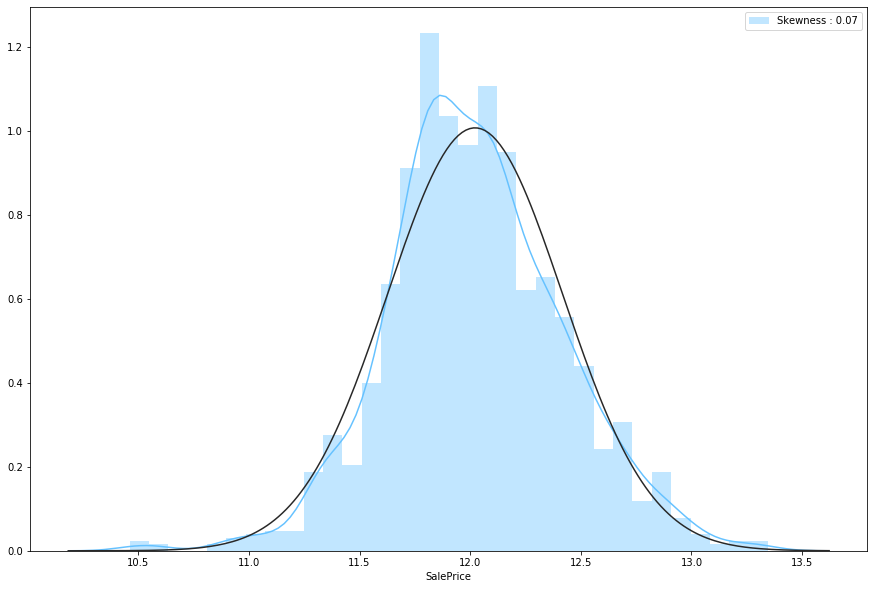

In [20]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y_train = train["SalePrice"]

#Check the new distribution 
plt.subplots(figsize=(15, 10))
g = sns.distplot(train['SalePrice'], fit=norm, label = "Skewness : %.2f"%(train['SalePrice'].skew()));
g = g.legend(loc="best")

On peut constater que les deux courbes se rejoignent grace à la Transforation Logarithmique qui a corrigé le biais et donne une distribution normale

***

<a id='treating_skewed_features'></a>
### 6.2 - Normalisation des variables numériques

Comme évoqué précédemment, les variables numériques asymétriques ne sont pas souhaitables lors de l'utilisation d'algorithmes d'apprentissage automatique. La raison pour laquelle nous voulons faire cela est d'éloigner le focus des modèles de toute valeur extrême, pour créer une solution généralisée. Nous pouvons apprivoiser ces valeurs extrêmes en transformant les variables biaisées.

Nous allons transformer les variables avec un biais > 0,5 pour suivre de plus près la distribution normale.

In [21]:
# liste des varaibles numériques
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check how skewed they are
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = skewed_feats[abs(skewed_feats) > 0.5]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print(skewness.shape[0],  "skewed numerical features have been Box-Cox transformed")

29 skewed numerical features have been Box-Cox transformed


In [27]:
# Liste des variables numeriques
print(list(numeric_feats))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'AgeHouse', 'RemodHouse', 'TotalArea', 'BathRoomBedRoom']


In [28]:
# Liste des variables catégorielles
categorical_feats = list(set(all_data.columns).difference(set(numeric_feats)))
print(categorical_feats)

['RoofStyle', 'GarageFinish', 'GarageType', 'Functional', 'MSZoning', 'BsmtExposure', 'Neighborhood', 'ExterQual', 'Exterior2nd', 'Electrical', 'Exterior1st', 'LotShape', 'SaleType', 'Foundation', 'KitchenQual', 'MiscFeature', 'Condition1', 'LandSlope', 'LotConfig', 'BsmtCond', 'MasVnrType', 'CentralAir', 'Heating', 'BsmtFinType2', 'BldgType', 'Fence', 'Street', 'PoolQC', 'HeatingQC', 'Condition2', 'PavedDrive', 'RoofMatl', 'Alley', 'LandContour', 'ExterCond', 'GarageQual', 'BsmtFinType1', 'SaleCondition', 'GarageCond', 'HouseStyle', 'FireplaceQu', 'BsmtQual']


<a id='preparation__of__cat__features'></a>
### 6.3 - Préparation des variables catégorielles

In [29]:
# Copie des données
all_data_copy = all_data.copy()

In [30]:
# Ls variables catégorielles ordonnées
# variables ayant pour echelle d'appréciation Ex,Gd,Ta,Fa,Po,Absent
var = ["BsmtQual", "BsmtCond", "GarageQual",
       "GarageCond", "ExterQual", "ExterCond",
       "HeatingQC", "KitchenQual"]

all_data_copy[var] = all_data_copy[var].apply(lambda x: x.astype(CategoricalDtype(
    categories=["Absent", "Po", "Fa", "Ta", "Gd", "Ex"],
    ordered=True)).cat.codes, axis=1)

In [31]:
# Autres variables
var = ["BsmtFinType1", "BsmtFinType2"]
all_data_copy[var] = all_data_copy[var].apply(lambda x: x.astype(CategoricalDtype(
    categories=["Absent", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ordered=True)).cat.codes, axis=1)

all_data_copy['GarageFinish'] = all_data_copy['GarageFinish'].astype(CategoricalDtype(
    categories=["Absent", "Unf", "RFn", "Fin"], ordered=True)).cat.codes

all_data_copy['BsmtExposure'] = all_data_copy['BsmtExposure'].astype(CategoricalDtype(
    categories=["Absent", "No", "Mn", "Av", "Gd"], ordered=True)).cat.codes

all_data_copy['LandSlope'] = all_data_copy['LandSlope'].astype(CategoricalDtype(
    categories=["Gtl", "Mod", "Sev"], ordered=True)).cat.codes

all_data_copy = all_data_copy.replace({'C (all)': 'Absent'})

all_data_copy.drop('Condition2', axis=1, inplace=True)

In [32]:
# Afficahge des valeurs initiales avant encoding
all_data[["LandSlope","BsmtExposure","GarageFinish","BsmtFinType1", "BsmtFinType2", "BsmtQual", "BsmtCond", "GarageQual",
       "GarageCond", "ExterQual", "ExterCond",
       "HeatingQC", "KitchenQual"]]

,LandSlope,BsmtExposure,GarageFinish,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,KitchenQual
0,Gtl,No,RFn,GLQ,Unf,Gd,TA,TA,TA,Gd,TA,Ex,Gd
1,Gtl,Gd,RFn,ALQ,Unf,Gd,TA,TA,TA,TA,TA,Ex,TA
2,Gtl,Mn,RFn,GLQ,Unf,Gd,TA,TA,TA,Gd,TA,Ex,Gd
3,Gtl,No,Unf,ALQ,Unf,TA,Gd,TA,TA,TA,TA,Gd,Gd
4,Gtl,Av,RFn,GLQ,Unf,Gd,TA,TA,TA,Gd,TA,Ex,Gd
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,Gtl,No,None,Unf,Unf,TA,TA,None,None,TA,TA,Gd,TA
2911,Gtl,No,Unf,Rec,Unf,TA,TA,TA,TA,TA,TA,TA,TA
2912,Gtl,No,Unf,ALQ,Unf,TA,TA,TA,TA,TA,TA,Ex,TA
2913,Gtl,Av,None,GLQ,Unf,Gd,TA,None,None,TA,TA,TA,TA


In [33]:
# Afficahge des même variables après encodage
all_data_copy[["LandSlope","BsmtExposure","GarageFinish","BsmtFinType1", "BsmtFinType2", "BsmtQual", "BsmtCond", "GarageQual",
       "GarageCond", "ExterQual", "ExterCond",
       "HeatingQC", "KitchenQual"]]

,LandSlope,BsmtExposure,GarageFinish,BsmtFinType1,BsmtFinType2,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,KitchenQual
0,0,1,2,6,1,4,-1,-1,-1,4,-1,5,4
1,0,4,2,5,1,4,-1,-1,-1,-1,-1,5,-1
2,0,2,2,6,1,4,-1,-1,-1,4,-1,5,4
3,0,1,1,5,1,-1,4,-1,-1,-1,-1,4,4
4,0,3,2,6,1,4,-1,-1,-1,4,-1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,0,1,-1,1,1,-1,-1,-1,-1,-1,-1,4,-1
2911,0,1,1,3,1,-1,-1,-1,-1,-1,-1,-1,-1
2912,0,1,1,5,1,-1,-1,-1,-1,-1,-1,5,-1
2913,0,3,-1,6,1,4,-1,-1,-1,-1,-1,-1,-1


#### Encodage des variables catégorielles avec One-hot encoding

In [39]:
print(all_data_copy.dtypes)

MSSubClass         float64
MSZoning            object
LotFrontage        float64
LotArea            float64
Street              object
                    ...   
SaleCondition       object
AgeHouse           float64
RemodHouse           int32
TotalArea          float64
BathRoomBedRoom    float64
Length: 78, dtype: object


In [40]:
# Liste des variables numériques après transformation des catégorielles ordonnées
var = all_data_copy.dtypes[all_data_copy.dtypes != "object"].index
print(list(var))

['MSSubClass', 'LotFrontage', 'LotArea', 'LandSlope', 'OverallQual', 'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'AgeHouse', 'RemodHouse', 'TotalArea', 'BathRoomBedRoom']


In [41]:
# Liste des variables catégorielles
nonVar = list(set(all_data_copy.columns).difference(set(var)))
print(nonVar)

['RoofStyle', 'GarageType', 'Functional', 'MSZoning', 'Neighborhood', 'Exterior2nd', 'Electrical', 'Exterior1st', 'LotShape', 'SaleType', 'Foundation', 'MiscFeature', 'Condition1', 'LotConfig', 'MasVnrType', 'CentralAir', 'Heating', 'BldgType', 'Fence', 'Street', 'PoolQC', 'PavedDrive', 'RoofMatl', 'Alley', 'LandContour', 'SaleCondition', 'HouseStyle', 'FireplaceQu']


In [42]:
all_data_copy[nonVar]

,RoofStyle,GarageType,Functional,MSZoning,Neighborhood,Exterior2nd,Electrical,Exterior1st,LotShape,SaleType,...,Fence,Street,PoolQC,PavedDrive,RoofMatl,Alley,LandContour,SaleCondition,HouseStyle,FireplaceQu
0,Gable,Attchd,Typ,RL,CollgCr,VinylSd,SBrkr,VinylSd,Reg,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Normal,2Story,None
1,Gable,Attchd,Typ,RL,Veenker,MetalSd,SBrkr,MetalSd,Reg,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Normal,1Story,TA
2,Gable,Attchd,Typ,RL,CollgCr,VinylSd,SBrkr,VinylSd,IR1,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Normal,2Story,TA
3,Gable,Detchd,Typ,RL,Crawfor,Wd Shng,SBrkr,Wd Sdng,IR1,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Abnorml,2Story,Gd
4,Gable,Attchd,Typ,RL,NoRidge,VinylSd,SBrkr,VinylSd,IR1,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Normal,2Story,TA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2910,Gable,None,Typ,RM,MeadowV,CmentBd,SBrkr,CemntBd,Reg,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Normal,2Story,None
2911,Gable,CarPort,Typ,RM,MeadowV,CmentBd,SBrkr,CemntBd,Reg,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Abnorml,2Story,None
2912,Gable,Detchd,Typ,RL,Mitchel,VinylSd,SBrkr,VinylSd,Reg,WD,...,None,Pave,None,Y,CompShg,None,Lvl,Abnorml,1Story,TA
2913,Gable,None,Typ,RL,Mitchel,Wd Shng,SBrkr,HdBoard,Reg,WD,...,MnPrv,Pave,None,Y,CompShg,None,Lvl,Normal,SFoyer,None


In [43]:
# Transformation des variables non numériques en objet
all_data_copy[nonVar] = all_data_copy[nonVar].apply(lambda x: x.astype(str))

# Nous allons tranformer toutes les autres variables en dummies
all_data_copy = pd.get_dummies(all_data_copy, columns=nonVar, sparse=True)
del var, nonVar

In [44]:
all_data_copy.head()

,MSSubClass,LotFrontage,LotArea,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA
0,5.684507,5.831328,19.212182,0,7,2.055642,8.059126,4,-1,4,...,0,1,0,0,0,0,0,1,0,0
1,3.858807,6.221214,19.712205,0,6,2.602594,0.000000,-1,-1,4,...,0,0,0,0,0,0,0,0,0,1
2,5.684507,5.914940,20.347241,0,7,2.055642,7.646538,4,-1,4,...,0,1,0,0,0,0,0,0,0,1
3,5.968981,5.684507,19.691553,0,7,2.055642,0.000000,-1,-1,-1,...,0,1,0,0,0,0,1,0,0,0
4,5.684507,6.314735,21.325160,0,8,2.055642,9.391827,4,-1,4,...,0,1,0,0,0,0,0,0,0,1


In [45]:
print(len(all_data.columns),
      ' colonnes et après encodage devient',
      len(all_data_copy.columns), 'colonnes')

79  colonnes et après encodage devient 239 colonnes


In [46]:
# recréons les données d'entrainement et test avec le df encodés
train = all_data_copy[:ntrain]
test = all_data_copy[ntrain:]

print(train.shape)
print(test.shape)

(1456, 239)
(1459, 239)


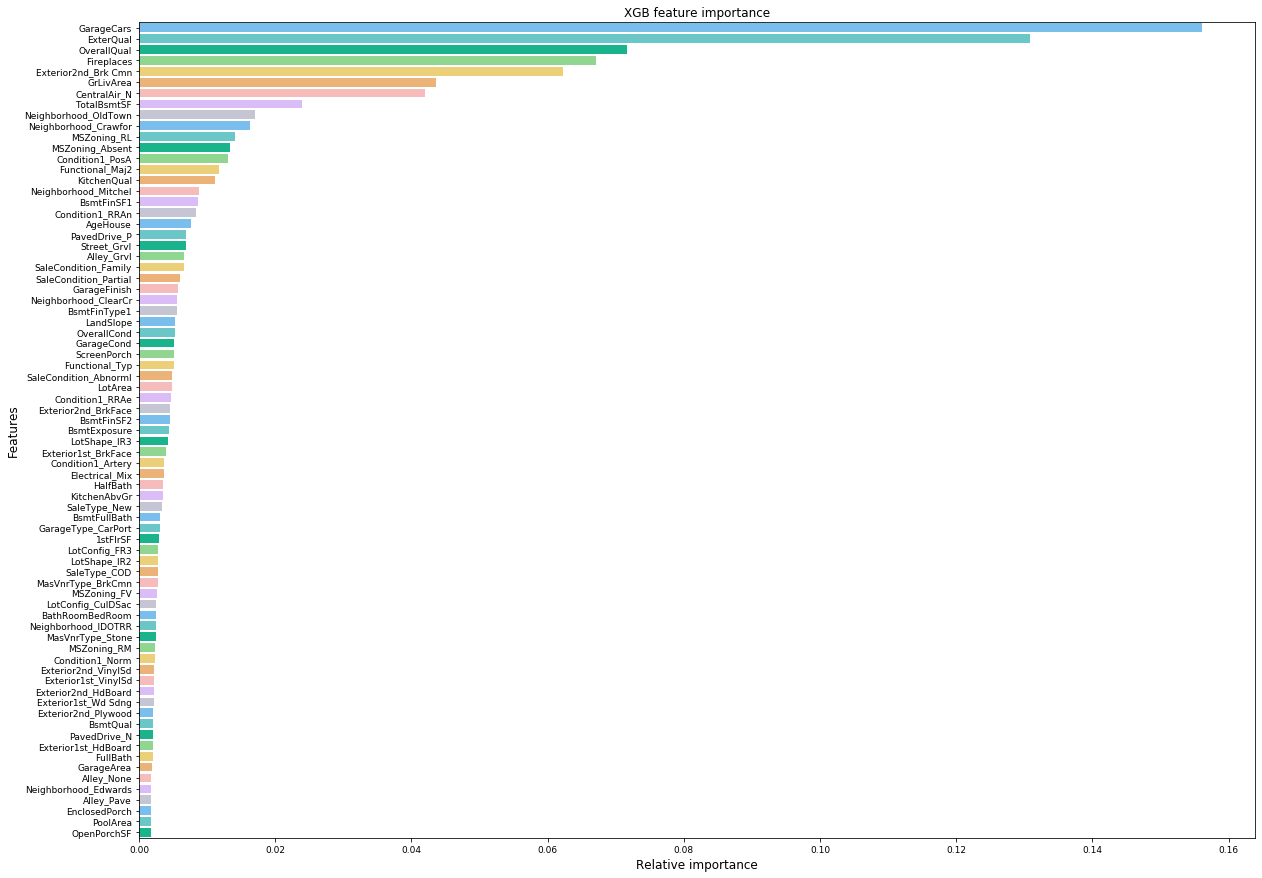

In [47]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(train, y_train)

# Sort feature importances from GBC model trained earlier
indices = np.argsort(model.feature_importances_)[::-1]
indices = indices[:75]

# Visualise these with a barplot
plt.subplots(figsize=(20, 15))
g = sns.barplot(y=train.columns[indices], x = model.feature_importances_[indices], orient='h', palette = mycolors)
g.set_xlabel("Relative importance",fontsize=12)
g.set_ylabel("Features",fontsize=12)
g.tick_params(labelsize=9)
g.set_title("XGB feature importance");

In [48]:
xgb_train = train.copy()
xgb_test = test.copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.fit(xgb_train, y_train)

# Autoriser l'attribut d'importation des fonctionnalités à sélectionner les fonctionnalités les plus importantes
xgb_feat_red = SelectFromModel(model, prefit = True)

# Redire les données 
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)


print("Results of 'feature_importances_':")
print('X_train: ', xgb_train.shape, '\nX_test: ', xgb_test.shape)

Results of 'feature_importances_':
X_train:  (1456, 39) 
X_test:  (1459, 39)


In [49]:
# Next we want to sample our training data to test for performance of robustness ans accuracy, before applying to the test data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)

# X_train = predictor features for estimation dataset
# X_test = predictor variables for validation dataset
# Y_train = target variable for the estimation dataset
# Y_test = target variable for the estimation dataset

print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (1019, 39) 
X_test:  (437, 39) 
Y_train:  (1019,) 
Y_test:  (437,)


***

<a id='modeling'></a>
# 7. 
## Modélisation

<a id='training'></a>
### 7.1 - Entrainement des modèles

Nous allons voir 8 algorithmes :
- **Kernel Ridge Regression**
- **Elastic Net**
- **Lasso**
- **Gradient Boosting**
- **Bayesian Ridge**
- **Lasso Lars IC**
- **Random Forest Regressor**
- **XGBoost**

La metrique utilisée sera le RMSE **Root Mean Squared Error**, comme decrit dans la competition Kaggle.

In [50]:
import xgboost as xgb
#Machine Learning Algorithm (MLA) Selection and Initialization
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
before_model_compare = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
    test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    before_model_compare.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",41.658,44.363
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",36.054,35.820
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",38.973,38.721
3,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",12.170,12.383
4,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_in...",11.722,12.505
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 2....",12.359,12.437
6,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",13.180,14.200
7,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",12.995,12.789


- Nous pouvons voir que chacun des modèles fonctionne avec des capacités variables, Bayesian Ridge ayant le meilleur score de précision sur l'ensemble de données d'entraînement et la précision sur l'ensemble de données de validation.

***

<a id='optimisation'></a>
### 7.2 - Optimisation

- Comme on peut le constater, les scores obtenus ne sont pas au top, c'est à cause de configuration par défaut de chaque modèle.

Donc, nous allons utiliser **GridSearchCV** pour trouver les valeurs des hyperparametres pour avoir les meilleurs scores possibles.


In [51]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",11.709,12.522
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",11.730,12.544
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",11.729,12.520
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",11.989,12.278
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...",11.722,12.505
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",12.359,12.437
6,RandomForestRegressor,"{'max_depth': None, 'max_features': 'auto', 'm...",13.283,13.979
7,XGBRegressor,"{'booster': 'gbtree', 'colsample_bylevel': 0.2...",11.804,11.869


Nous constatons que sur tous les modèles, les scores(RMSE) ont diminué, donc nos configurations sont efficaces.

Mais il est encore possible d'ameliorer notre algorithme en combinant les différents modèles pour n'avoir qu'un seul modèle.

***

<a id='stacking'></a>
### 7.3 - Combinaison des modèles

Pour avoir un modèle final plus performant et plus stable avec très peu de variance, il existe plusieurs façons de combiner les modèles comme :
-	La combinaison par vote simple : VotingRegressor()
-	La combinaison par vote pondérée : VotingRegressor() en précisant les poids de chaque modèle
-	Le Stacking : StackingRegressor(), traitement sur 2 niveaux de modélisation :
 Mais nous allons nous concentrer sur ce dernier dans notre projet

Les deux niveaux sont :
- Les modèles de bases 
- le meta-modèle qui prendra en parametre les résultats de prédiction des modèles de base 

In [52]:
#Define our base and meta models for stacking
kfold = KFold(n_splits=10)

base_models = (KernelRidge(),
               make_pipeline(RobustScaler(),Lasso(alpha=0.0005, random_state=1)),
               make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005, l1_ratio=0.9)),             
               make_pipeline(StandardScaler(),GradientBoostingRegressor(learning_rate=0.005, 
                                                                        loss='huber',
                                                                        max_depth=4, 
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=15,
                                                                        min_samples_split=10,
                                                                        n_estimators=3000,
                                                                        random_state=1)))
meta_model = LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, 
                           feature_fraction=0.2319, feature_fraction_seed=9,
                           learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
                           min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
                           bagging_seed=9,objective='regression')

#Building the stacking model

stack = StackingCVRegressor(regressors=base_models,
                            meta_regressor=meta_model, 
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,cv=kfold,
                            random_state=1)

In [53]:
#fitting the model to our data
stack.fit(X_train, Y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


StackingCVRegressor(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                    meta_regressor=LGBMRegressor(bagging_fraction=0.8,
                                                 bagging_freq=5, bagging_seed=9,
                                                 feature_fraction=0.2319,
                                                 feature_fraction_seed=9,
                                                 learning_rate=0.05, max_bin=55,
                                                 min_data_in_leaf=6,
                                                 min_sum_hessian_in_leaf=11,
                                                 n_estimators=720, num_leaves=5,
                                                 objective='regression'),
                    random_state=1,
                    reg...
                                                 ElasticNet(alpha=0.0005,
                                                            l1_ratio=0.9))]),
                          

In [47]:
#see the results of the model for training

stack_score = round(stack.score(X_train, Y_train)*100, 3)
predictions = stack.predict(X_train)
stack_rmse = round(np.sqrt(mean_squared_error(Y_train, predictions).mean())*100, 3)
print(' _'*15)
print('\nStacking Results for training train : \n')
print(f'Score : {stack_score}%')
print(f'RMSE  : {stack_rmse}%')
print(' _'*15)

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Stacking Results for training test : 

Score : 96.197%
RMSE  : 7.798%
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


In [48]:
#see the results of the model for test

stack_score_test = round(stack.score(X_test, Y_test)*100, 3)
predictions_test = stack.predict(X_test)
stack_rmse_test = round(np.sqrt(mean_squared_error(Y_test, predictions_test).mean())*100, 3)
print(' _'*15)
print('\nStacking Results for test : \n')
print(f'Score : {stack_score_test}%')
print(f'RMSE  : {stack_rmse_test}%')
print(' _'*15)

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Stacking Results for test : 

Score : 89.946%
RMSE  : 12.213%
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


<a id='submission'></a>
### 7.4 - Sauvegarde du résultat

In [56]:
#lets make the predictions for the submission 

price_predicted = np.expm1(stack.predict(xgb_test)) #using expm1 (The inverse of log1p)

In [57]:
submission = pd.DataFrame({
        "Id": test_ID,
        "SalePrice": price_predicted })
submission.to_csv('data/submissionTest_17_05_2021.csv', index=False)

***

<a id='conclusion'></a>
# 8. 
## Conclusion

- Nous avons pu voir dans ce notebook, les differentes étapes de preparation des données, en passant par le remplissage des valeurs manquantes, suppression des variables non renseignées et non impactantes, une première modelisation, puis l'optimisation des valeurs des parametres et à la fin la technique d'empilement des modèles.
- Des améliorations peuvent-etre apportés sur la partie "features ingeenering" avec une bonne connaissance de chaque variable et beaucoup de tests.

***